In [1]:
!pip install -r requirements.txt

In [5]:
import os
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['LOKY_MAX_CPU_COUNT'] = '1'
warnings.filterwarnings('ignore')

In [7]:
def gmm_grid_search(X_data, max_components=10):
    best_bic = np.inf
    best_params = {'n_components': None, 'covariance_type': None}
    best_gmm = None
    
    n_components_range = range(2, max_components + 1)
    cov_types = ['full', 'tied', 'diag', 'spherical']
    
    for n in n_components_range:
        for cv_type in cov_types:
            try:
                gmm = GaussianMixture(n_components=n, covariance_type=cv_type, random_state=42)
                gmm.fit(X_data)
                
                # Calculate BIC (Lower is better)
                bic = gmm.bic(X_data)
                
                if bic < best_bic:
                    best_bic = bic
                    best_params = {'n_components': n, 'covariance_type': cv_type}
                    best_gmm = gmm
            except:
                continue
                
    return best_params, best_bic, best_gmm


In [9]:
# Load Data & Preprocessing
df = pd.read_csv('Mall_Customers.csv')

# Encode Genre (Male=0, Female=1)
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])

target = 'Spending Score (1-100)'
feats_to_compare = ['Genre_Code', 'Age', 'Annual Income (k$)']
all_feats = feats_to_compare + [target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df[all_feats])

Feature              | Best N | Cov Type   | BIC        | Time (s)  
---------------------------------------------------------------------------
Genre_Code           | 2      | tied       | -1511.87     | 0.39137
Age                  | 4      | diag       | 1069.94     | 0.53238
Annual Income (k$)   | 5      | diag       | 1041.68     | 0.41927


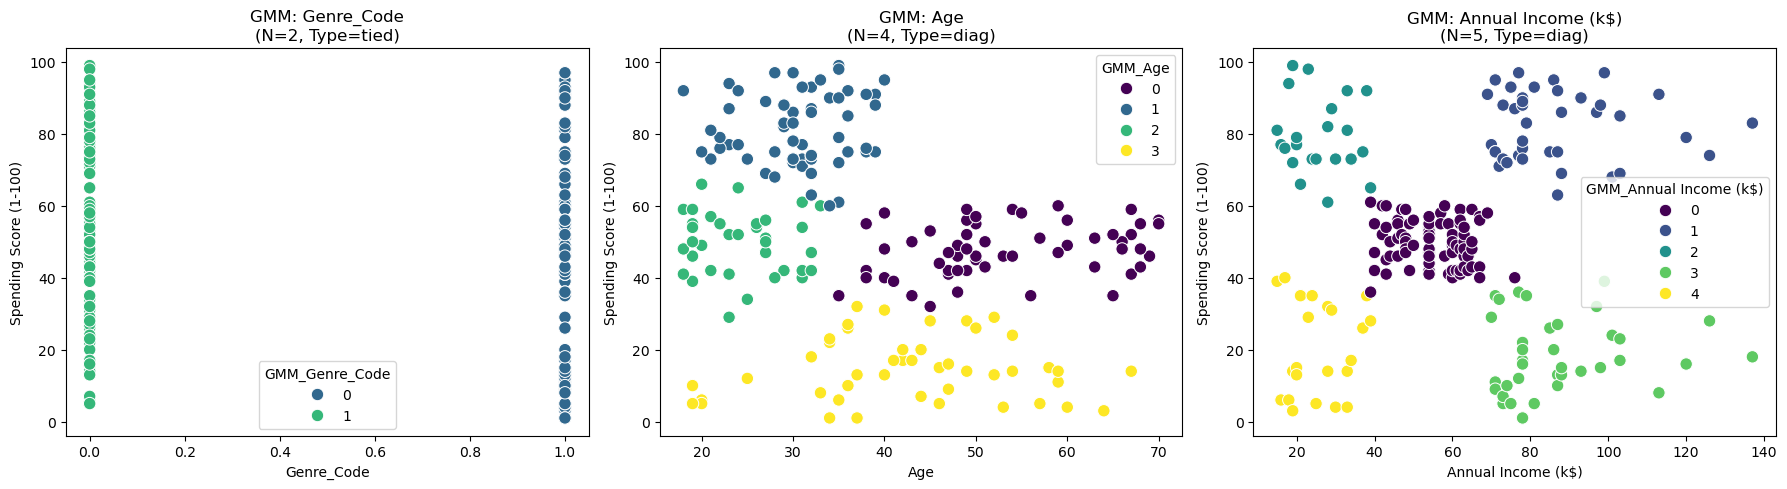

In [11]:
# GMM Grid Search
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print(f"{'Feature':<20} | {'Best N':<6} | {'Cov Type':<10} | {'BIC':<10} | {'Time (s)':<10}")
print("-" * 75)

for i, feat in enumerate(feats_to_compare):
    # 1. Prepare Data
    X_pair = df[[feat, target]].values
    X_pair_scaled = scaler.fit_transform(X_pair)
    
    # 2. Run Grid Search & Time it
    start = time.time()
    best_params, best_bic, best_gmm = gmm_grid_search(X_pair_scaled)
    labels = best_gmm.predict(X_pair_scaled)
    elapsed = time.time() - start
    
    n_comp = best_params['n_components']
    cov_type = best_params['covariance_type']
    
    print(f"{feat:<20} | {n_comp:<6} | {cov_type:<10} | {best_bic:.2f}     | {elapsed:.5f}")
    
    # --- Plot: Scatter Plot ---
    cluster_col = f'GMM_{feat}'
    df[cluster_col] = labels
    
    sns.scatterplot(x=df[feat], y=df[target], hue=df[cluster_col], 
                    palette='viridis', ax=axes[i], legend='full', s=80)
    axes[i].set_title(f'GMM: {feat}\n(N={n_comp}, Type={cov_type})')

plt.tight_layout()
plt.show()


Global Result | N=5 | Type=diag | BIC=-369.55 | Time=0.4597s


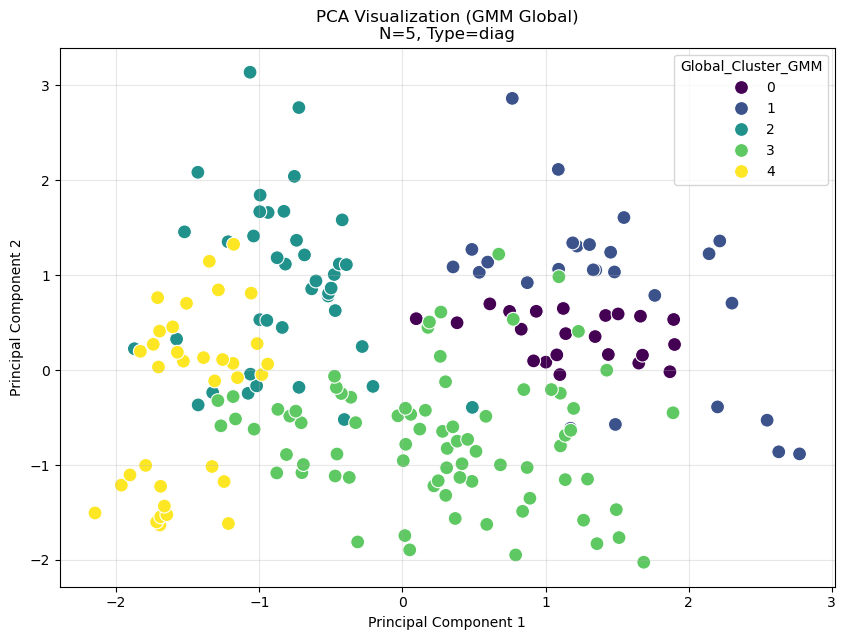

In [13]:
#Global GMM & PCA
start = time.time()
best_params_global, best_bic_global, best_gmm_global = gmm_grid_search(X_all_scaled)
labels_global = best_gmm_global.predict(X_all_scaled)
elapsed = time.time() - start

print(f"Global Result | N={best_params_global['n_components']} | Type={best_params_global['covariance_type']} | BIC={best_bic_global:.2f} | Time={elapsed:.4f}s")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

df['PCA_1'] = X_pca[:, 0]
df['PCA_2'] = X_pca[:, 1]
df['Global_Cluster_GMM'] = labels_global

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Global_Cluster_GMM', data=df, palette='viridis', s=100)
plt.title(f'PCA Visualization (GMM Global)\nN={best_params_global["n_components"]}, Type={best_params_global["covariance_type"]}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()